In [141]:
import operators
from data_management import IPDataset
import config
import torch
import matplotlib.pyplot as plt
import numpy as np


### Device setup

In [142]:
device = torch.device("cuda")


### Dataset setup

In [143]:
test_data = IPDataset("test", config.DATA_PATH)
samples = range(50, 100)
X_0 = torch.stack([test_data[s][0] for s in samples])


In [144]:
X_0.shape


torch.Size([50, 1, 256, 256])

### Plot single image from dataset

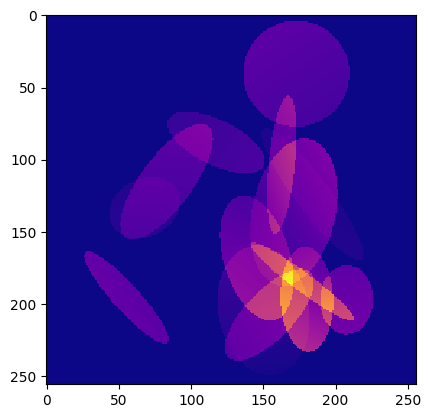

In [145]:
plt.imshow(X_0[0, :, :].squeeze(0), cmap="plasma")


### Initialize wavelet operator

In [146]:
level = 2
input_shape = [256, 256]
W = operators.Wavelet(input_shape, device, level)


In [147]:
W.get_in_shape()


[256, 256]

In [148]:
W.get_out_shape()


(269, 269)

### Test single image and batch processing

In [149]:
X_0.shape


torch.Size([50, 1, 256, 256])

In [150]:
y_single = W.dot(X_0[0, :, :])
y_batch = W.dot(X_0)
print("single output vector shape:", y_single.shape)
print("output vector batch shape:", y_batch.shape)


single output vector shape: torch.Size([1, 72361])
output vector batch shape: torch.Size([50, 1, 72361])


In [151]:
y_single_image = operators.vec2im(y_single, W.get_out_shape())
y_batch_image = operators.vec2im(y_batch, W.get_out_shape())
print("single output image shape:", y_single_image.shape)
print("output image batch shape:", y_batch_image.shape)


single output image shape: torch.Size([1, 269, 269])
output image batch shape: torch.Size([50, 1, 269, 269])


In [152]:
y_single_image_numpy = y_single_image.cpu().detach().numpy()
y_batch_image_numpy = y_batch_image.cpu().detach().numpy()
y_single_image_numpy = np.squeeze(y_single_image_numpy, axis=0)
y_batch_image_numpy = np.squeeze(y_batch_image_numpy, axis=1)


/tmp/ipykernel_9322/2584393391.py:2: RuntimeWarning: divide by zero encountered in log10
  np.log10(y_single_image_numpy), interpolation="nearest", cmap="plasma"
/tmp/ipykernel_9322/2584393391.py:2: RuntimeWarning: invalid value encountered in log10
  np.log10(y_single_image_numpy), interpolation="nearest", cmap="plasma"


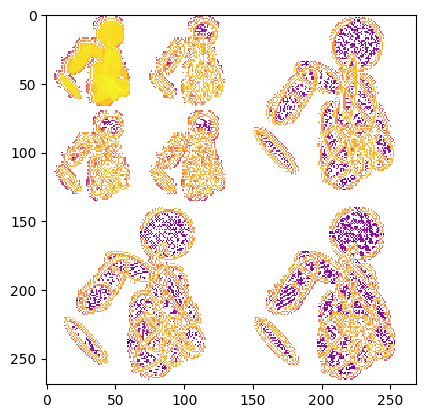

In [153]:
plt.imshow(
    np.log10(y_single_image_numpy), interpolation="nearest", cmap="plasma"
)


/tmp/ipykernel_9322/3193802479.py:2: RuntimeWarning: divide by zero encountered in log10
  np.log10(y_batch_image_numpy[0, :, :]),
/tmp/ipykernel_9322/3193802479.py:2: RuntimeWarning: invalid value encountered in log10
  np.log10(y_batch_image_numpy[0, :, :]),


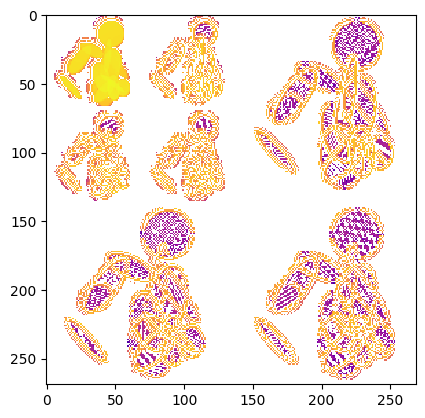

In [154]:
plt.imshow(
    np.log10(y_batch_image_numpy[0, :, :]),
    interpolation="nearest",
    cmap="plasma",
)


In [155]:
b_single = W.adj(y_single)


In [156]:
b_batch = W.adj(y_batch)


In [157]:
b_batch = W.adj(y_batch)
b_single = W.adj(y_single)
print("computed inverse batch shape:", b_batch.shape)
print("computed inverse single image shape", b_single.shape)


computed inverse batch shape: torch.Size([50, 256, 256])
computed inverse single image shape torch.Size([256, 256])


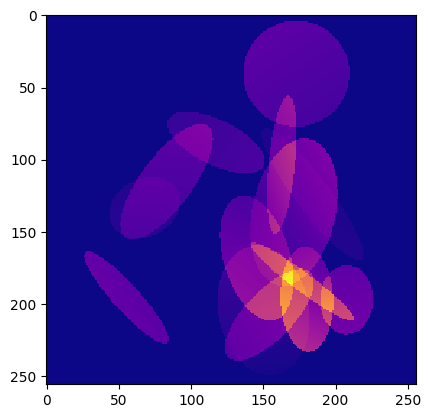

In [158]:
b_single_plot = b_batch[0, :, :].cpu().detach().numpy()
plt.imshow(b_single_plot, cmap="plasma")


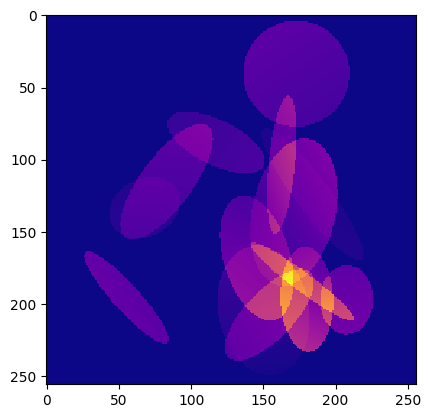

In [159]:
b_batch_plot = b_batch.cpu().detach().numpy()[0, :, :]
plt.imshow(b_batch_plot, cmap="plasma")


In [160]:
b_single_plot.shape


(256, 256)

In [161]:
import reconstruction_methods


In [162]:
mask_func = operators.RadialMaskFunc(config.n, 40)
mask = operators.unprep_fft_channel(mask_func((1, 1) + config.n + (1,)))
OpA = operators.Fourier(mask)
OpW = W


In [163]:
def wavelet_reconstruction(y, lam, rho):
    x, _ = reconstruction_methods.admm_l1_rec(
        y,
        OpA,
        OpW,
        OpA.adj(y),
        OpW(OpA.adj(y)),
        lam,
        rho,
        iter=10,
        silent=False,
    )
    return x


In [164]:
X_0 = operators.to_complex(X_0.to(device))
X_0.shape


torch.Size([50, 2, 256, 256])

In [165]:
### Measurent vectors y = P_omega \circ Fx + eps
Y_ref = operators.noise_gaussian(OpA.dot(X_0), 10)
Y_ref.shape


torch.Size([50, 2, 10941])

In [166]:
x_naive = OpA.adj(Y_ref)


In [167]:
x_rec = wavelet_reconstruction(Y_ref, 9e-7, 1e-5)


ADMM iterations: 100%|██████████| 10/10 [01:58<00:00, 11.85s/it, dres=0.00013, loss=0.00373, pres=12.9]


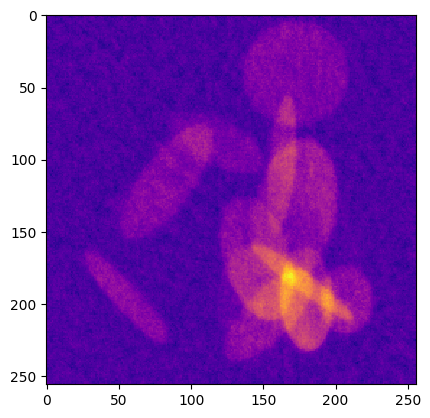

In [169]:
plt.imshow(x_naive[0, 0, :, :].detach().cpu().numpy(), cmap="plasma")


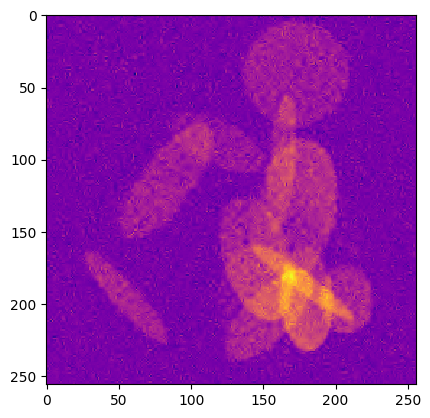

In [170]:
plt.imshow(x_rec[0, 0, :, :].detach().cpu().numpy(), cmap="plasma")
